In [ ]:
import torch
import pandas as pd
from torchvision import transforms
from torch import nn
import os
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from tqdm import tqdm
from time import sleep
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cuda')

In [ ]:
train_cols = ["ISOR", "CAPE", "TCWV", "TCC", "TCW", "IRB", "B10B", "B16B", "B11B", "I2B", "WVB", "B09B"]

In [ ]:
class RainDataset(Dataset):
    def __init__(self, img_dirs_file):
        self.df = pd.read_csv(img_dirs_file, skiprows=[249])
       
        self.img_dirs = self.df[train_cols]
        self.gt_dirs = self.df["radar"]
        self.imerg = self.df["IMERG"]
        

    def __len__(self):
        return len(self.img_dirs)

    def __getitem__(self, i):
        raw_input = []
        # print(i)
        for j in range(len(self.img_dirs.loc[i])):
            # print(j)
            raw_input.append(self.get_tensor(self.img_dirs.loc[i][j]))
        input = []
        for j in range(5):
          input.append(raw_input[j])
        input.append(raw_input[train_cols.index("IRB")])
        input.append(torch.sub(raw_input[train_cols.index("B10B")], raw_input[train_cols.index("B16B")]))
        input.append(torch.sub(raw_input[train_cols.index("B11B")], raw_input[train_cols.index("IRB")]))
        input.append(torch.sub(raw_input[train_cols.index("IRB")], raw_input[train_cols.index("I2B")]))
        input.append(torch.sub(raw_input[train_cols.index("WVB")], raw_input[train_cols.index("B09B")]))
        input.append(torch.sub(raw_input[train_cols.index("B09B")], raw_input[train_cols.index("B10B")]))
        input = torch.stack((input))
        gt = self.get_tensor(self.gt_dirs[i]).reshape(1, 512, 512)
        return input, gt

    def get_imerg(self, i):
        imerg = self.get_tensor(self.imerg.loc[i])
        return imerg
    
    def get_tensor(self, path):
        img = gdal.Open(path)
        img_arr = img.GetRasterBand(1).ReadAsArray()
        img_tensor = torch.from_numpy(img_arr)
        return img_tensor

In [ ]:
dataset = RainDataset("/content/drive/MyDrive/Dataset3/sampling.csv")

In [ ]:
from torch.utils.data.dataset import random_split

def split_train_val_test(dataset, val_ratio=0.1, test_ratio=0.2):
    test_length = int(len(dataset) * test_ratio)
    val_length = int(len(dataset) * val_ratio)
    train_length = len(dataset) - val_length - test_length
    return random_split(
        dataset, lengths=[train_length, val_length, test_length]
    )

# dataset = TensorDataset(ds)
np.random.seed(0)
torch.manual_seed(0)

train_ds, val_ds, test_ds = split_train_val_test(dataset)

In [ ]:
class ResidualAttentionUNet(nn.Module):
  def __init__(self, inputChannel=11, outputChannel=1):
    super().__init__()
    # Downsampling
    self.conv1 = DownSampleWithAttention(inputChannel, 32)
    self.conv2 = DownSampleWithAttention(32, 64)
    self.conv3 = DownSampleWithAttention(64, 128)
    self.conv4 = DownSampleWithAttention(128, 256)
    self.conv5 = DownSampleWithAttention(256, 512)

    self.resblock1 = ResBlock(512, 512)
    self.resblock2 = ResBlock(512, 512)
    self.resblock3 = ResBlock(512, 512)

    # Upsampling
    self.upconv1 = UpSampleWithAttention(512, 256)
    self.upconv2 = UpSampleWithAttention(512, 128)
    self.upconv3 = UpSampleWithAttention(256, 64)
    self.upconv4 = UpSampleWithAttention(128, 32)
    self.upconv5 = UpSampleWithAttention(64, 32)
    self.classification = nn.Sequential(
            nn.Conv2d(32, outputChannel, kernel_size=1),
        )

  def forward(self, x):
    scale128, sa128down = self.conv1(x)
    scale64, sa64down = self.conv2(scale128)
    scale32, sa32down = self.conv3(scale64)
    scale16, sa64down = self.conv4(scale32)
    scale8, sa8down = self.conv5(scale16)
    scale8, sa8down = self.resblock1(scale8)
    scale8, sa8down = self.resblock2(scale8)
    scale8, sa8down = self.resblock3(scale8)
    upscale16, sa16up = self.upconv1(scale8)
    upscale16 = torch.cat([upscale16, scale16], dim=1)
    upscale32, sa32up = self.upconv2(upscale16)
    upscale32 = torch.cat([upscale32, scale32], dim=1)
    upscale64, sa64up = self.upconv3(upscale32)
    upscale64 = torch.cat([upscale64, scale64], dim=1)
    upscale128, sa128up = self.upconv4(upscale64)
    upscale128 = torch.cat([upscale128, scale128], dim=1)
    upscale256, sa256up = self.upconv5(upscale128)
    finaloutput = self.classification(upscale256)
    return finaloutput

class AttConv(nn.Module):
    def __init__(self, inputChannel, outputChannel):
        super().__init__()
        self.convolution = nn.Sequential(
            nn.Conv2d(inputChannel, outputChannel, kernel_size=3, padding=1),
            nn.BatchNorm2d(outputChannel),
            nn.LeakyReLU(0.2),
            nn.Conv2d(outputChannel, outputChannel, kernel_size=3, padding=1),
            nn.BatchNorm2d(outputChannel),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(2)
        )
        self.ca = ChannelAttention(outputChannel)
        self.sa = SpatialAttention()
    
    def forward(self,x):
        x = self.convolution(x)
        caOutput = self.ca(x)
        x = caOutput * x
        saOutput = self.sa(x)
        x = saOutput * x
        return x, saOutput

class ResBlock(nn.Module):
    def __init__(self, inputChannel, outputChannel, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(inputChannel, outputChannel, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(outputChannel)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(outputChannel, outputChannel, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(outputChannel)
        self.downsample = downsample
        self.ca = ChannelAttention(outputChannel)
        self.sa = SpatialAttention()
        
    def forward(self, x):
        res = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            res = self.downsample(x)
        out += res
        out = self.relu(out)
        caOutput = self.ca(out)
        out = caOutput * out
        saOutput = self.sa(out)
        out = saOutput * out
        return out, saOutput

class AttnUpConv(nn.Module):
    def __init__(self, inputChannel, outputChannel):
        super().__init__()
        self.convolution = nn.Sequential(
            nn.Conv2d(inputChannel, outputChannel, kernel_size=3, padding=1),
            nn.BatchNorm2d(outputChannel),
            nn.LeakyReLU(0.2),
            nn.Conv2d(outputChannel, outputChannel, kernel_size=3, padding=1),
            nn.BatchNorm2d(outputChannel),
            nn.LeakyReLU(0.2)
        )
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.ca = ChannelAttention(outputChannel)
        self.sa = SpatialAttention()
    
    def forward(self, x):
        x = self.upsample(x)
        x = self.convolution(x)
        caOutput = self.ca(x)
        x = caOutput * x
        saOutput = self.sa(x)
        x = saOutput * x
        return x, saOutput

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
           
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=False),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

In [ ]:
batch_size = 2
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

torch.Size([2, 11, 512, 512])
torch.Size([2, 1, 512, 512])


In [ ]:
def train_epoch(model, optimizer, train_dataloader):
    model.train()
    total_loss = 0
    correct = 0
    total_correct = 0
    y_true, y_pred = [], []

    with tqdm(train_dataloader, unit="batch") as epoch:
      for x, y in epoch:
        x = x.to(device)
        y = y.to(device)

        out = model(x)
        mask = y >= 0
        
        y = y[mask]
        
        out = out[mask]
        
        loss = loss_func(out, y)
        
        pred = out.cpu().detach().numpy()
        target = y.cpu().detach().numpy()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch.set_postfix(loss=loss.item())
        sleep(0.1)

        total_loss += (loss.item())  

    total_loss = round(total_loss/(len(train_dataloader)), 4)
    return total_loss

def val_epoch(model, val_dataloader):
    model.eval()
    total_correct = 0
    total_loss = 0

    with tqdm(val_dataloader, unit="batch") as epoch:
      for x, y in epoch:
        with torch.no_grad():
          x = x.to(device)
          y = y.to(device)

          out = model(x)
          mask = y >= 0
          
          y = y[mask]

          out = out[mask]
          loss = loss_func(out, y)
          
          pred = out.cpu().detach().numpy()
          target = y.cpu().detach().numpy()

          total_loss += (loss.item())

          epoch.set_postfix(loss=loss.item())
          sleep(0.1)
            
    total_loss = round(total_loss / len(val_dataloader), 4)
    
    return total_loss

def test(model, test_dataloader):
  total_correct = 0
  total_loss = 0
  y_true, y_pred = [], []

  model.eval()
  with tqdm(test_dataloader, unit="batch") as tepoch:
    for x, y in tepoch:
      with torch.no_grad():
        x = x.to(device)
        y = y.to(device)

        out = model(x)
        
        y_true.append(y)
        
        mask = y >= 0
        
        y = y[mask]
        
        y_pred.append(out)
        out = out[mask]
        loss = loss_func(out, y)

        pred = out.cpu().detach().numpy()
        target = y.cpu().detach().numpy()

        total_loss += (loss.item())
    
        tepoch.set_postfix(loss=loss.item())
        sleep(0.1)

  total_loss = round(total_loss / len(test_dataloader), 4)

  return total_loss, y_pred, y_true

In [ ]:
model_save_name = 'model_resatt_hima_full.pt'
path = F"/content/drive/MyDrive/model/{model_save_name}" 
def save_model(model):
  torch.save(model.state_dict(), path)

In [ ]:
model = ResidualAttentionUNet()
loss_func = nn.MSELoss()
arr_lr = [0.1, 0.01, 0.001, 1e-4, 5e-4]
lr = arr_lr[3]
optimizer = torch.optim.Adam(model.parameters(), lr)

In [ ]:
n_epoch = 5
arr_n_epoch = [15]

best_model = model
best_acc = 0

min_loss = 6.9546

img_width = 512
img_height = 512

for n_ep in arr_n_epoch:
  print('-' * 50)
  print(f'Number of epoch: {n_ep} \nLearning rate: {lr} -- Batch size: {batch_size} -- Optimizer: Adam')
  n_epoch = n_ep
  # model_cls.to(device)
  model.to(device)

  for epoch in range(n_epoch):

    print(f"Epoch {epoch + 1} started")
    
    train_loss = train_epoch(model, optimizer, train_dataloader)
    val_loss = val_epoch(model, val_dataloader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if (val_loss < min_loss):
      best_model = model
      min_loss = val_loss
      save_model(best_model)
      
    print(f"  Train Loss     : {format(train_loss, '.4f')}")
    print(f"  Validation Loss: {format(val_loss, '.4f')}")

--------------------------------------------------
Number of epoch: 15 
Learning rate: 0.0001 -- Batch size: 2 -- Optimizer: Adam
Epoch 1 started


100%|██████████| 13/13 [00:04<00:00,  2.74batch/s, loss=8.86]


  Train Loss     : 4.3382
  Validation Loss: 6.9502
Epoch 2 started


100%|██████████| 13/13 [00:04<00:00,  2.75batch/s, loss=9.56]


  Train Loss     : 4.3065
  Validation Loss: 7.2777
Epoch 3 started


100%|██████████| 13/13 [00:04<00:00,  2.79batch/s, loss=11.4]


  Train Loss     : 4.2462
  Validation Loss: 7.2701
Epoch 4 started


100%|██████████| 13/13 [00:04<00:00,  2.75batch/s, loss=12.6]


  Train Loss     : 4.4463
  Validation Loss: 7.8451
Epoch 5 started


100%|██████████| 13/13 [00:04<00:00,  2.74batch/s, loss=9.59]


  Train Loss     : 4.2594
  Validation Loss: 6.9678
Epoch 6 started


100%|██████████| 13/13 [00:04<00:00,  2.67batch/s, loss=8.94]


  Train Loss     : 4.1173
  Validation Loss: 7.1677
Epoch 7 started


100%|██████████| 13/13 [00:05<00:00,  2.58batch/s, loss=8.35]


  Train Loss     : 4.1345
  Validation Loss: 6.9673
Epoch 8 started


100%|██████████| 13/13 [00:05<00:00,  2.51batch/s, loss=8.87]


  Train Loss     : 4.0466
  Validation Loss: 6.8815
Epoch 9 started


100%|██████████| 13/13 [00:05<00:00,  2.55batch/s, loss=8.41]


  Train Loss     : 4.1108
  Validation Loss: 7.2422
Epoch 10 started


100%|██████████| 13/13 [00:05<00:00,  2.55batch/s, loss=8.92]


  Train Loss     : 4.0141
  Validation Loss: 6.9761
Epoch 11 started


100%|██████████| 13/13 [00:04<00:00,  2.65batch/s, loss=10.2]


  Train Loss     : 4.1408
  Validation Loss: 6.9382
Epoch 12 started


100%|██████████| 13/13 [00:04<00:00,  2.74batch/s, loss=9.65]


  Train Loss     : 4.0006
  Validation Loss: 7.4768
Epoch 13 started


100%|██████████| 13/13 [00:04<00:00,  2.77batch/s, loss=8.88]


  Train Loss     : 3.9847
  Validation Loss: 7.0006
Epoch 14 started


100%|██████████| 13/13 [00:04<00:00,  2.73batch/s, loss=9.25]


  Train Loss     : 3.8754
  Validation Loss: 7.1159
Epoch 15 started


100%|██████████| 13/13 [00:04<00:00,  2.78batch/s, loss=8.22]

  Train Loss     : 3.9644
  Validation Loss: 7.1291


In [ ]:
min_loss

6.9546

In [ ]:
model.to(device)
test_loss, pred, target = test(model, test_dataloader)
print(f"  Test Loss: {format(test_loss, '.4f')}")

100%|██████████| 26/26 [00:10<00:00,  2.58batch/s, loss=8.32]

  Test Loss: 9.8869


In [ ]:
import os
from osgeo import ogr, osr

def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Byte)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(4326)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

In [ ]:
!pip install rasterio --quiet

In [ ]:
import rasterio
from rasterio.plot import show

def show_img(path):
  img = rasterio.open(path)
  show(img)

In [ ]:
def plot(target_path, pred_path):
  target = rasterio.open(target_path)
  pred = rasterio.open(pred_path)

  fig, (axt, axp) = plt.subplots(1,2, figsize=(10,10))
  show(target, ax=axt, title='target')
  show(pred, ax=axp, title='predict')
  plt.show()

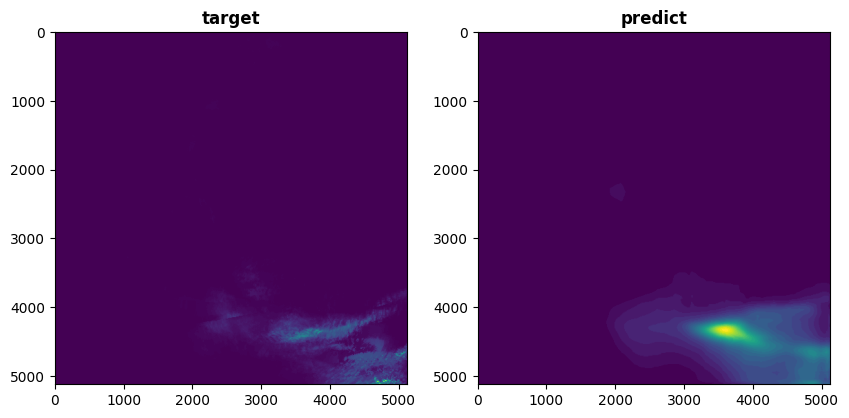

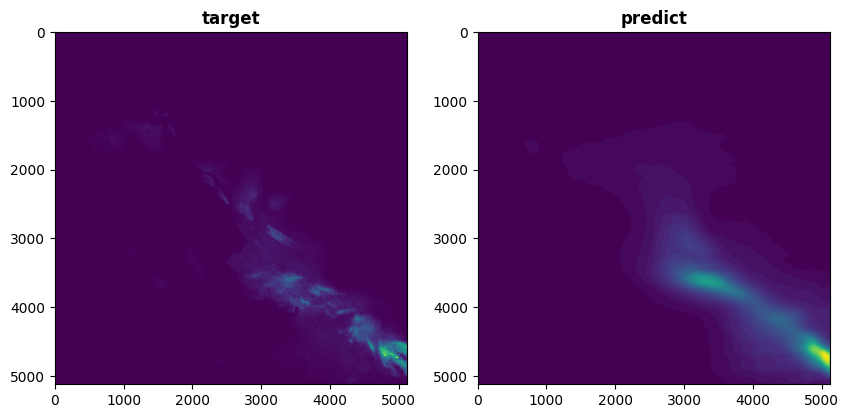

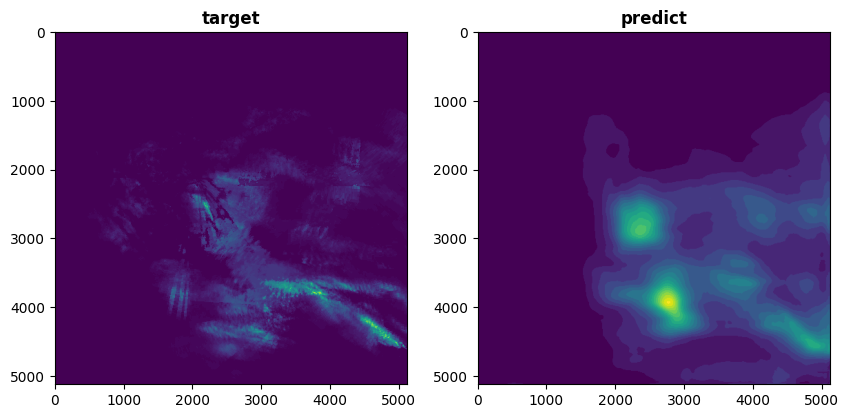

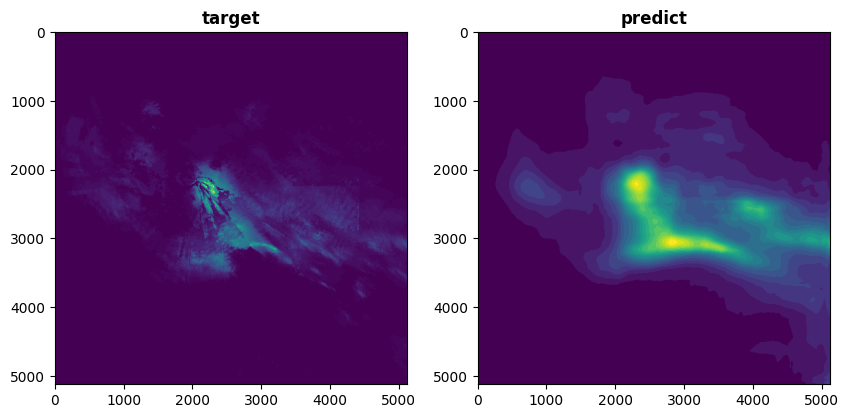

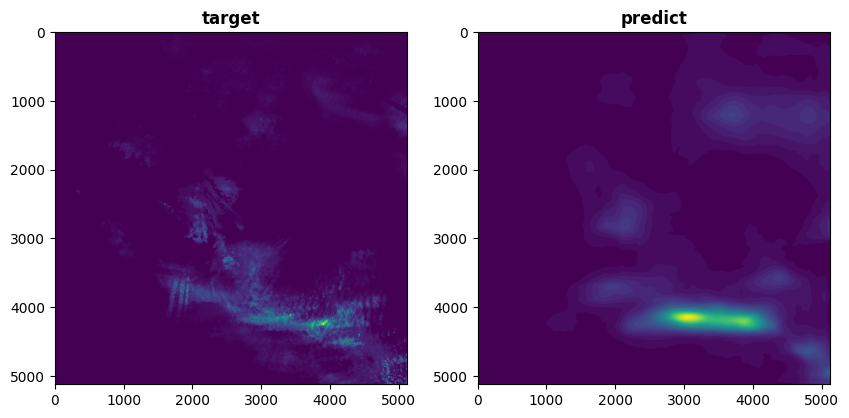

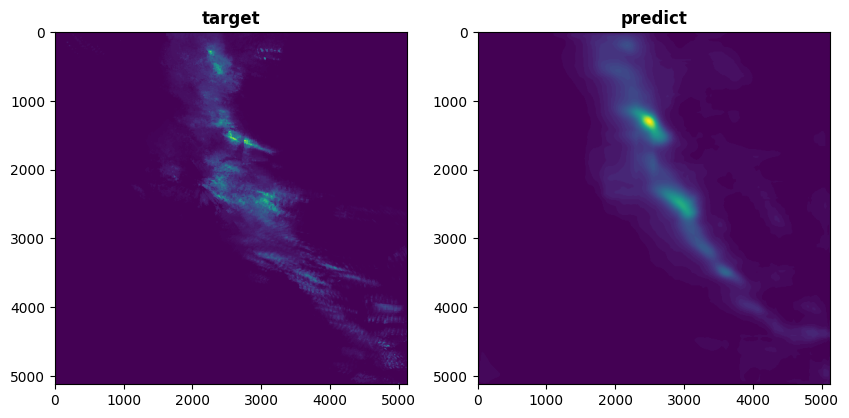

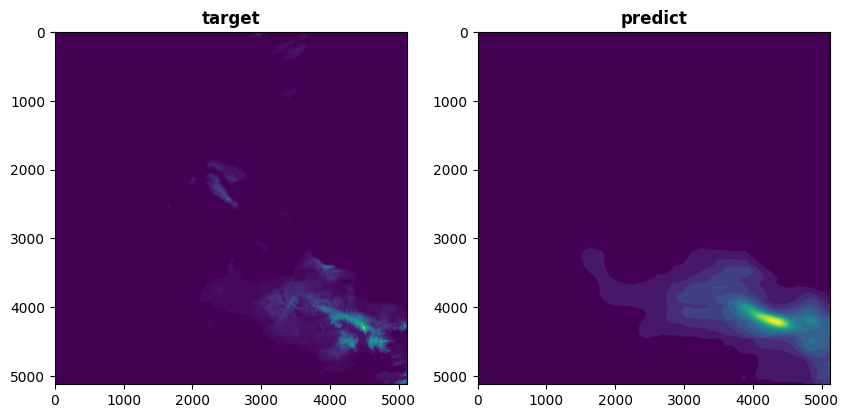

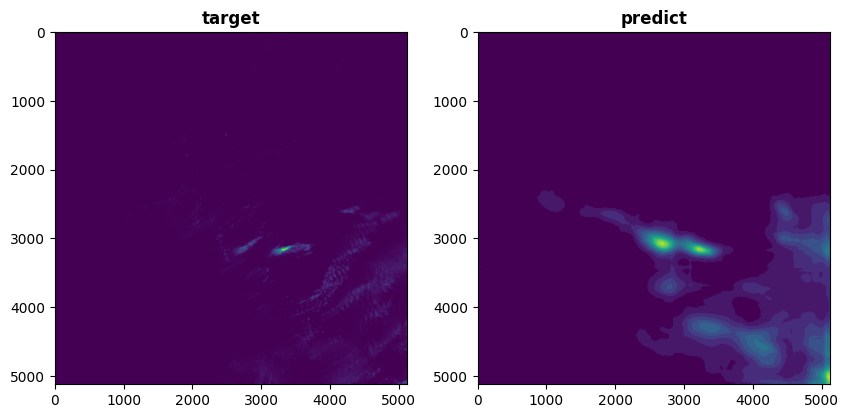

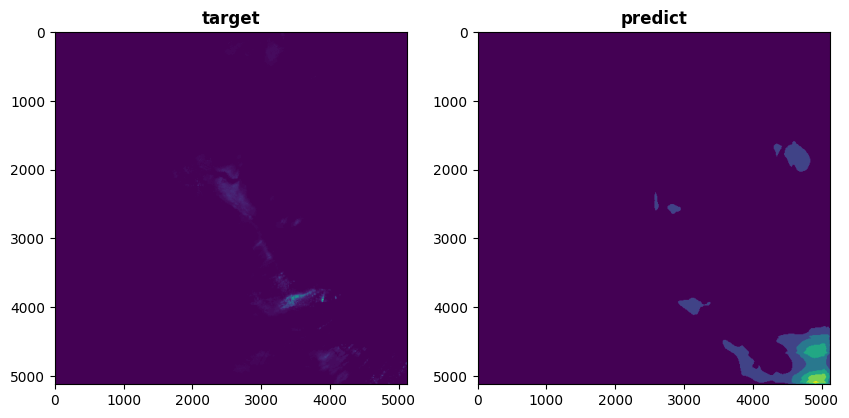

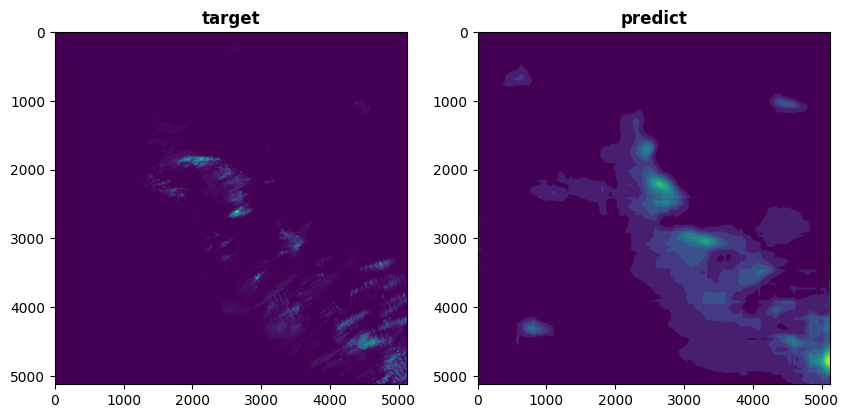

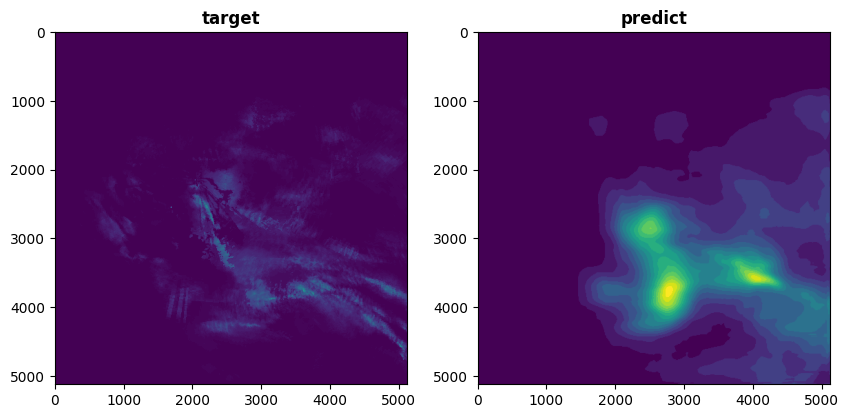

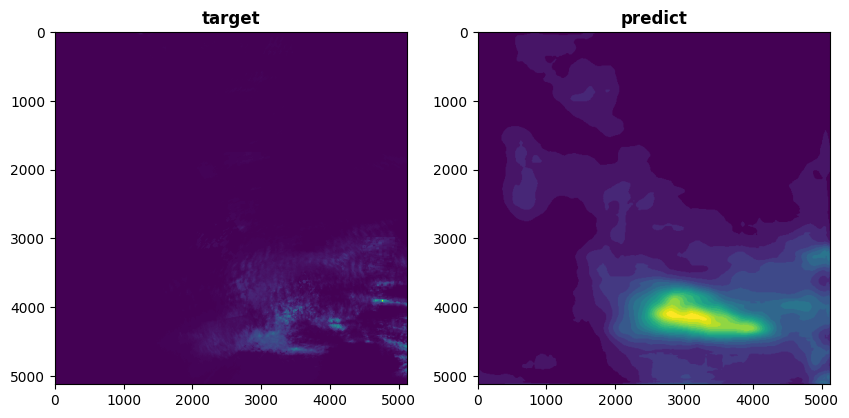

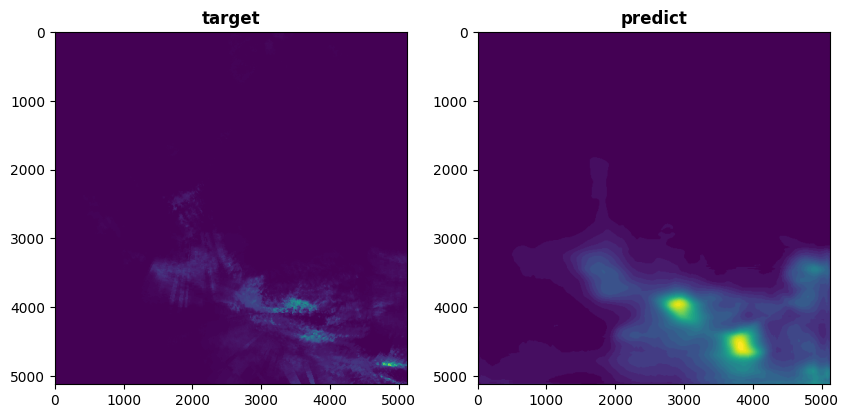

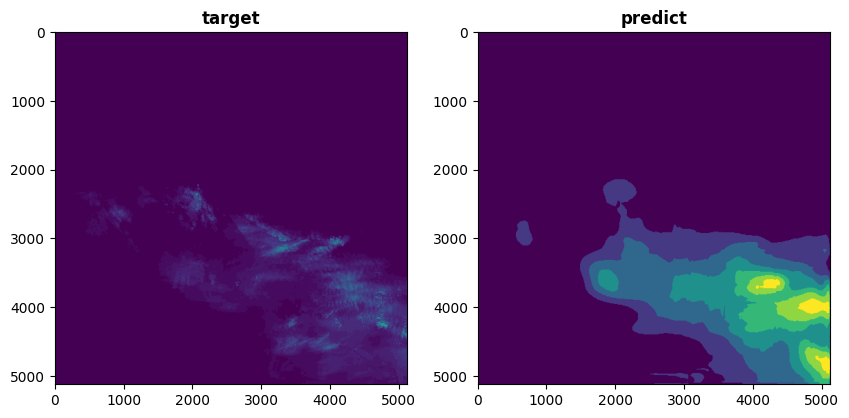

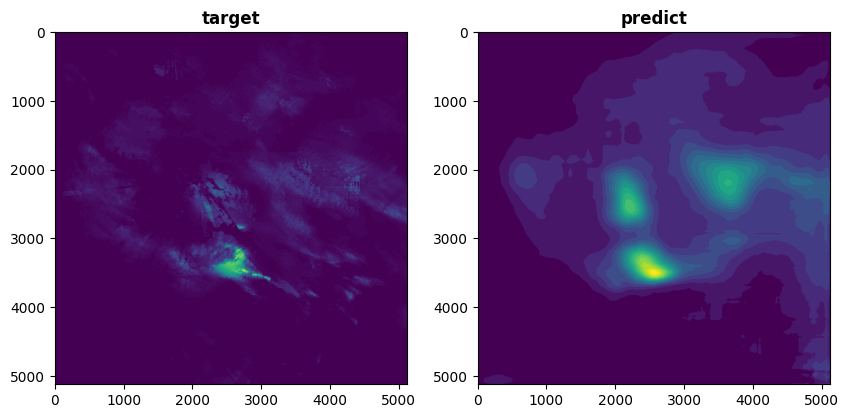

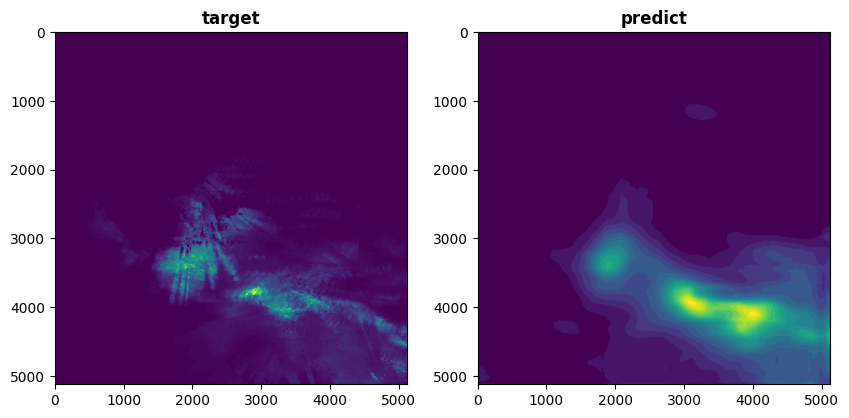

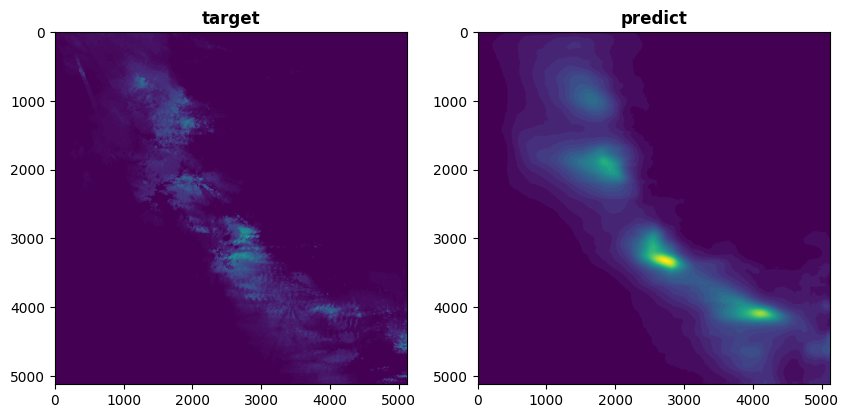

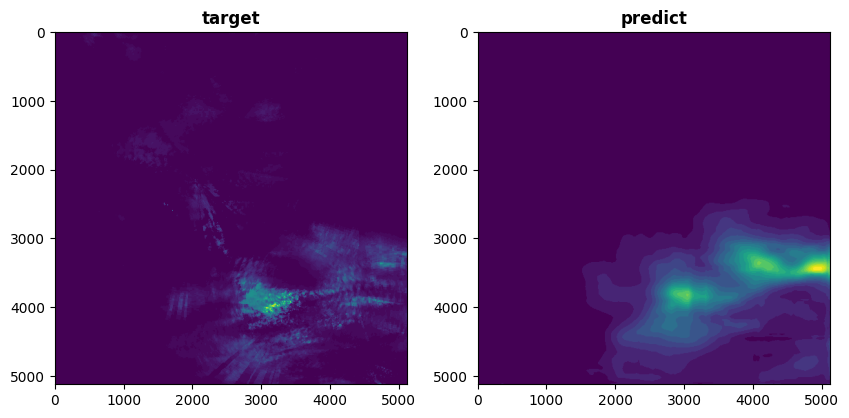

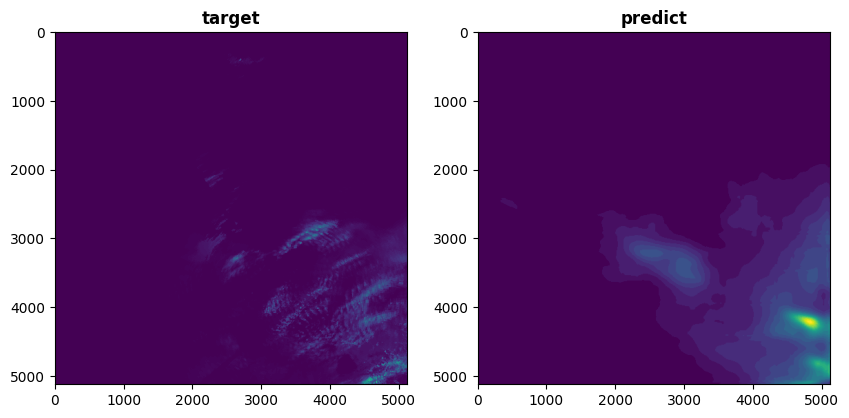

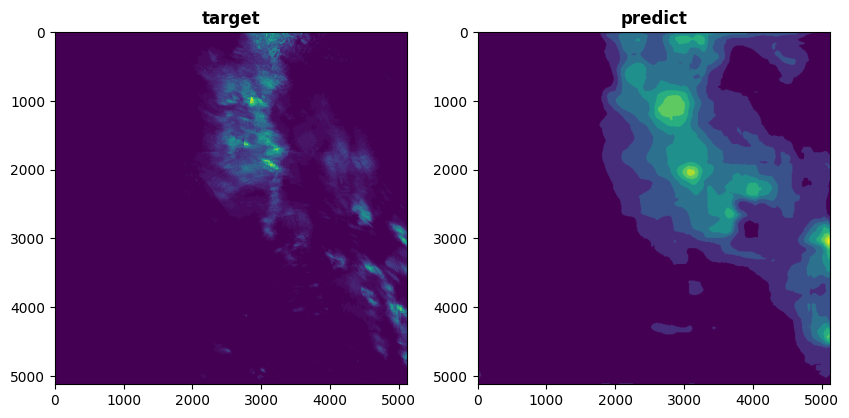

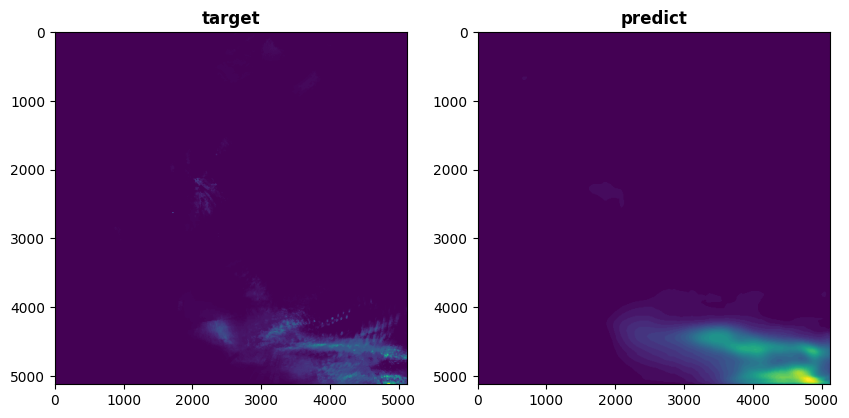

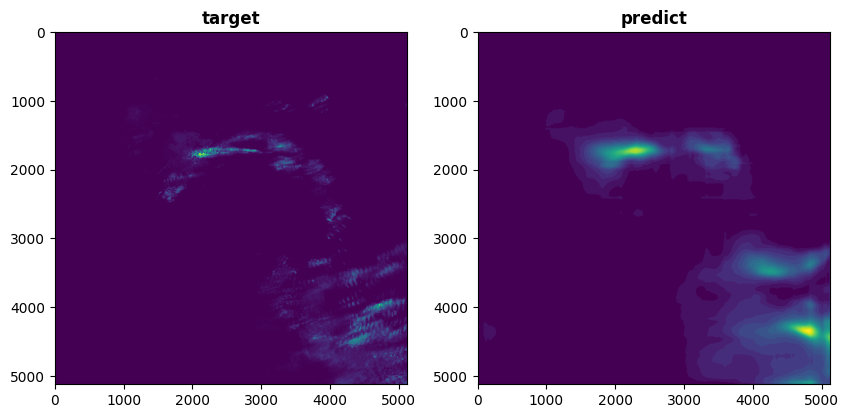

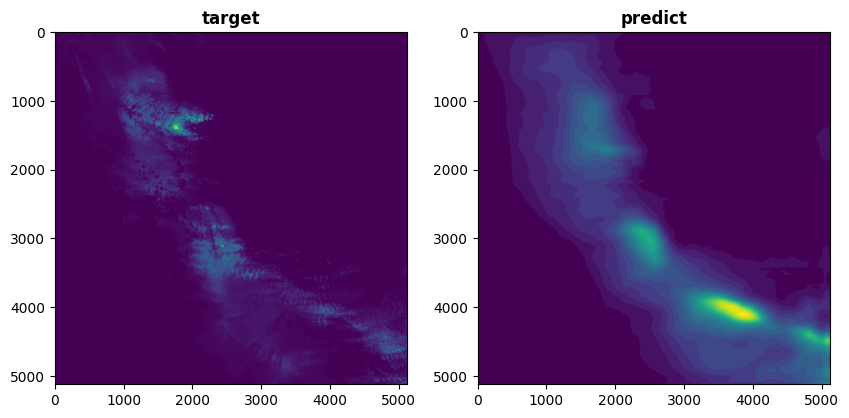

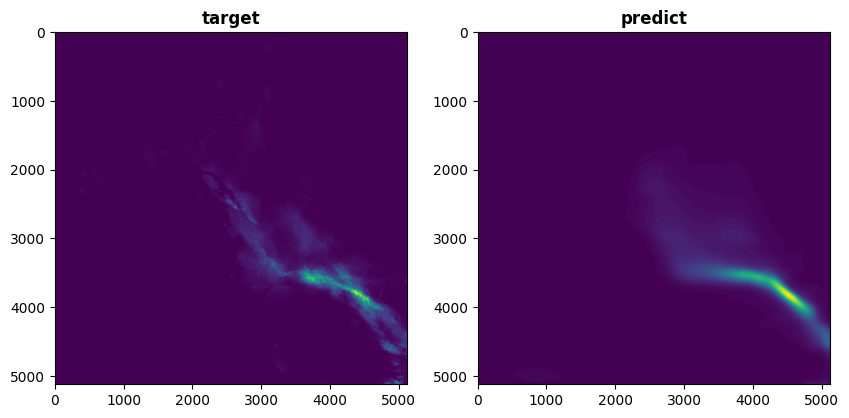

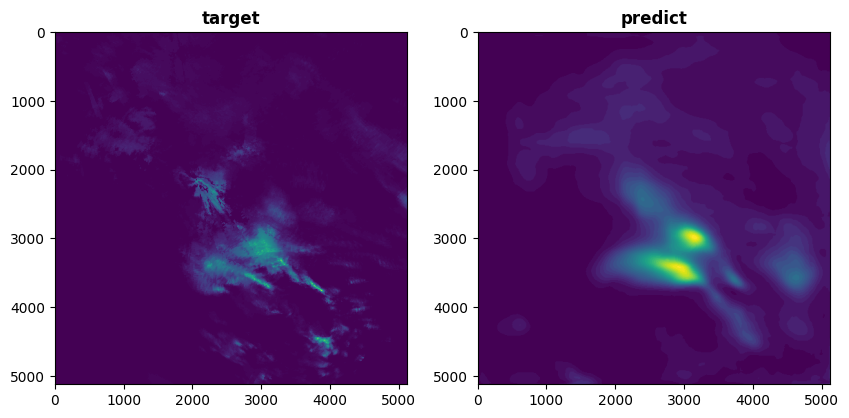

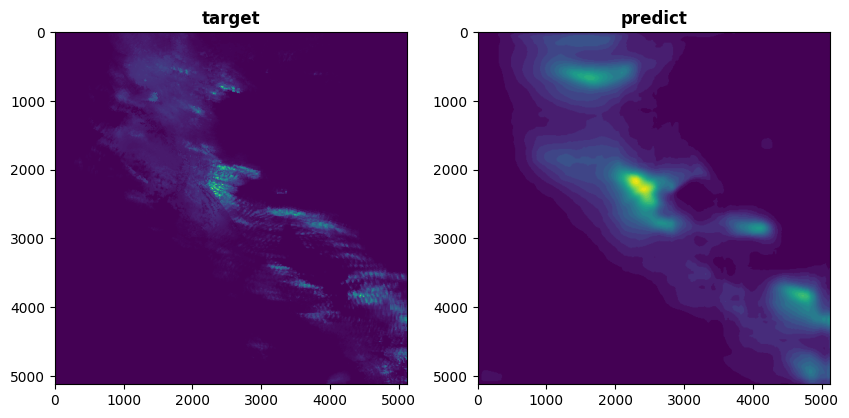

In [ ]:
rasterOrigin = (-123.25745,45.43013)
rasterOrigin_2 = (0, 0)
pixelWidth = 10
pixelHeight = 10
count = 0
for i in range(13):
  for j in range(batch_size):
    count = count + 1
    array2raster('pred_%x.tif'%(i * 10 + j), rasterOrigin_2, pixelWidth, pixelHeight, pred[i][j].cpu().squeeze(0).numpy())
    array2raster('target_%x.tif'%(i * 10 + j), rasterOrigin_2, pixelWidth, pixelHeight, target[i][j].cpu().squeeze(0).numpy())
    plot('target_%x.tif'%(i * 10 + j), 'pred_%x.tif'%(i * 10 + j))

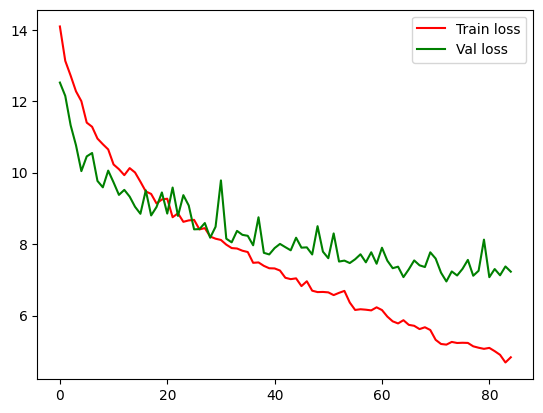

In [ ]:
plt.figure(1)
plt.plot(train_losses, 'r', label='Train loss')
plt.plot(val_losses, 'g', label='Val loss')
plt.legend()
plt.show()